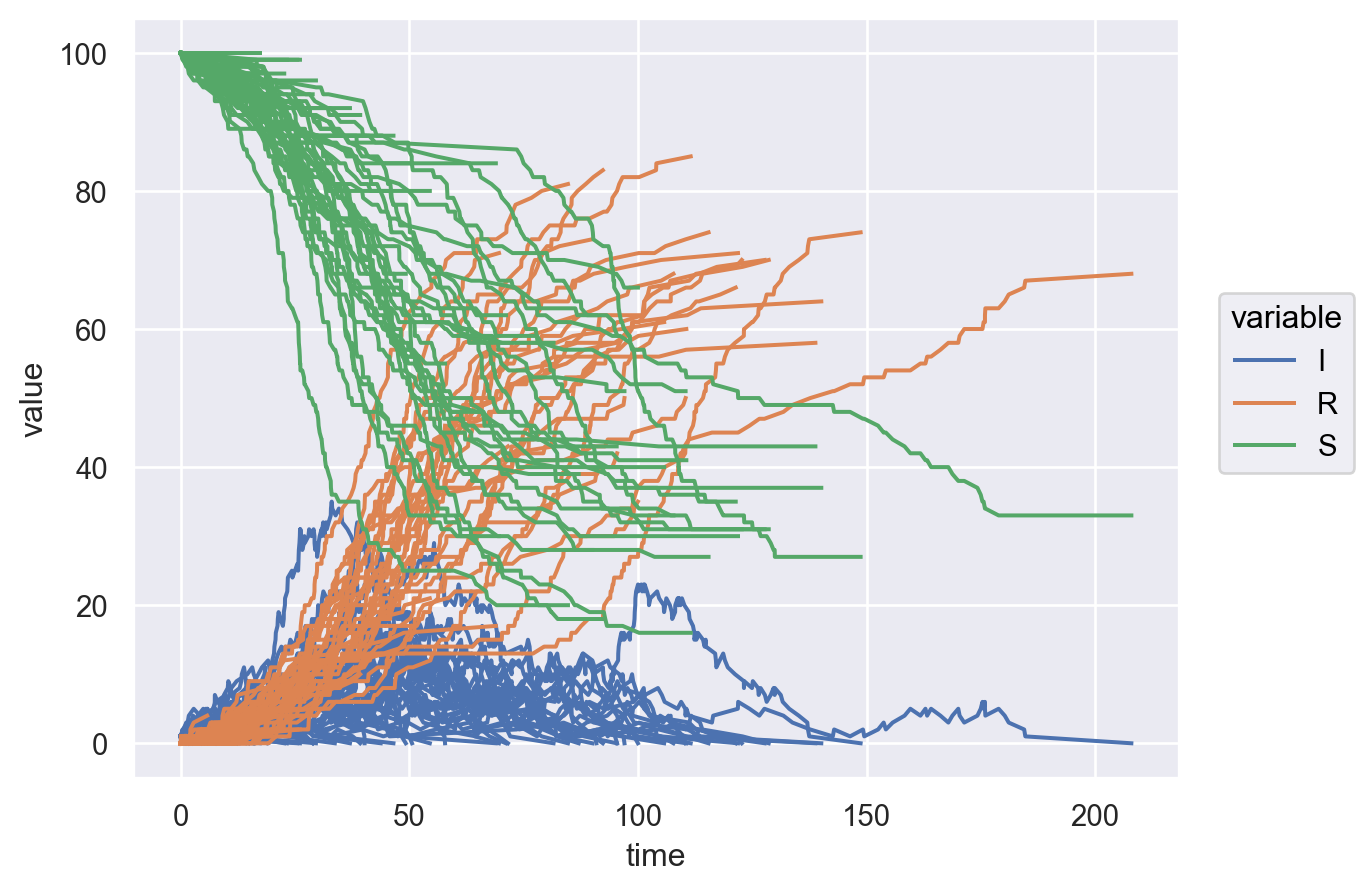

In [147]:
import seaborn.objects as so
import xarray

from simbio import Compartment, Species, initial, reactions
from simbio.simulators.rebop import to_rebop


class Model(Compartment):
    S: Species = initial(default=100)
    I: Species = initial(default=1)
    R: Species = initial(default=0)

    r_infect = reactions.Synthesis(A=S, B=I, AB=2 * I, rate=0.0015)
    r_cure = reactions.Conversion(A=I, B=R, rate=0.1)


sim = to_rebop(Model)

df = (
    xarray.concat([sim(1000, 0) for _ in range(100)], dim="seed")
    .to_dataframe()
    .melt(ignore_index=False)
    .reset_index()
)
so.Plot(df, x="time", y="value", color="variable", group="seed").add(so.Lines())

In [195]:
import dataclasses
from typing import Iterable

import rebop
from poincare import Variable
from poincare.compile import Compiled, build_equation_maps
from symbolite.abstract import symbol
from symbolite.core import substitute
from symbolite.impl import libstd

from simbio import Simulator
from simbio.core import RateLaw

hat_pow = dataclasses.replace(symbol.pow, fmt="{} ^ {}")


def to_rebop(model: type[Compartment]) -> Compiled[Variable, rebop.Gillespie]:
    def yield_variables(species: Iterable[Species], /):
        for s in species:
            if not isinstance(s.stoichiometry, int):
                raise TypeError("stoichiometry must be an integer")

            name = str(s.variable)
            for _ in range(s.stoichiometry):
                yield name

    def get_rate_expression(reaction: RateLaw, /):
        rate = reaction.rate_law
        rate = str(substitute(rate, {symbol.pow: hat_pow}))
        rate = rate.replace(".", "__")  # dots not allowed (yet?)
        return rate

    sim = rebop.Gillespie()
    for reaction in model._yield(RateLaw):
        sim.add_reaction(
            get_rate_expression(reaction),
            list(yield_variables(reaction.reactants)),
            list(yield_variables(reaction.products)),
        )

    compiled = build_equation_maps(Model)
    return Compiled(
        independent=compiled.independent,
        variables=compiled.variables,
        parameters=compiled.parameters,
        mapper=compiled.mapper,
        func=sim,
        output=compiled.output,
        libsl=libstd,
    )


sim = Simulator(Model)
sim.compiled = to_rebop(Model)

In [206]:
p = sim.create_problem()
y = dict(zip(map(str, sim.compiled.variables), map(int, p.y)))
p = dict(zip(map(str, sim.compiled.parameters), map(int, p.p)))
# sim.compiled.func.run(y, 10, 10, params=p)
p

{'r_cure.rate': 0, 'r_infect.rate': 0}